## Loan default prediction using machine learning.

### Part 1. Data Exploration and Additional Data Cleaning: 
* Finding and Fixing Anomalies in the data.
* Looking at distributions of continuous variables.
* Analyzing counts of different cases for discrete variables, and corresponding ratios for every case.

Dataset as found on Kaggle: https://www.kaggle.com/zaurbegiev/my-dataset

DataQubit, 2019

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import style

Loading dataset cleaned and prepared in the Part 0 of this project (see previous Jupyter notebook)

In [4]:
df_loan = pd.read_csv('train_test_data_nondup/df_loan_train.csv')

## Data Exploration Phase

### Renaming the Columns

In [5]:
df_loan.columns

Index(['Loan ID', 'Customer ID', 'Loan Status', 'Current Loan Amount', 'Term',
       'Credit Score', 'Annual Income', 'Years in current job',
       'Home Ownership', 'Purpose', 'Monthly Debt', 'Years of Credit History',
       'Months since last delinquent', 'Number of Open Accounts',
       'Number of Credit Problems', 'Current Credit Balance',
       'Maximum Open Credit', 'Bankruptcies', 'Tax Liens'],
      dtype='object')

I will rename columns to avoid spaces in the column names, and lower the capital characters.

In [6]:
col_rename = {'Current Loan Amount': 'cur_loan_amount', 'Years in current job': 'yrs_job',
             'Home Ownership': 'home_own', 'Years of Credit History': 'yrs_credit', 
             'Months since last delinquent': 'months_delinq', 'Number of Open Accounts': 'num_acc',
             'Number of Credit Problems': 'num_probl', 'Current Credit Balance': 'cur_bal',
             'Maximum Open Credit': 'max_open', 'Bankruptcies':'bankrupt'} 

In [7]:
df_loan.rename(columns=col_rename, inplace=True)

df_loan.columns = ['_'.join(item.lower().split()) for item in df_loan.columns]

In [8]:
df_loan.head()

,loan_id,customer_id,loan_status,cur_loan_amount,term,credit_score,annual_income,yrs_job,home_own,purpose,monthly_debt,yrs_credit,months_delinq,num_acc,num_probl,cur_bal,max_open,bankrupt,tax_liens
0,4771cc26-131a-45db-b5aa-537ea4ba5342,2de017a3-2e01-49cb-a581-08169e83be29,Fully Paid,262328.0,Short Term,NaN,NaN,10+ years,Home Mortgage,Debt Consolidation,33295.98,21.1,8.0,35.0,0.0,229976.0,850784.0,0.0,0.0
1,4eed4e6a-aa2f-4c91-8651-ce984ee8fb26,5efb2b2b-bf11-4dfd-a572-3761a2694725,Fully Paid,99999999.0,Short Term,741.0,2231892.0,8 years,Own Home,Debt Consolidation,29200.53,14.9,29.0,18.0,1.0,297996.0,750090.0,0.0,0.0
2,77598f7b-32e7-4e3b-a6e5-06ba0d98fe8a,e777faab-98ae-45af-9a86-7ce5b33b1011,Fully Paid,347666.0,Long Term,721.0,806949.0,3 years,Own Home,Debt Consolidation,8741.90,12.0,NaN,9.0,0.0,256329.0,386958.0,0.0,0.0
3,89d8cb0c-e5c2-4f54-b056-48a645c543dd,4ffe99d3-7f2a-44db-afc1-40943f1f9750,Charged Off,206602.0,Short Term,7290.0,896857.0,10+ years,Home Mortgage,Debt Consolidation,16367.74,17.3,NaN,6.0,0.0,215308.0,272448.0,0.0,0.0
4,273581de-85d8-4332-81a5-19b04ce68666,90a75dde-34d5-419c-90dc-1e58b04b3e35,Fully Paid,217646.0,Short Term,730.0,1184194.0,< 1 year,Home Mortgage,Debt Consolidation,10855.08,19.6,10.0,13.0,1.0,122170.0,272052.0,1.0,0.0


Next, let's convert our target variable (Loan status) to zero or one values, where 'Charged Off' would be represented by 1 (positive class, as we want to predict the default), and 'Fully Paid' by 0 (negative class):

In [16]:
#Convert class to integer:
df_loan['loan_status'] = (df_loan.loan_status=='Charged Off').astype(int)

Let's also create two dataframes representing negative and positive classes. This would just simplify some of the scripting.

In [17]:
neg_class = df_loan[(df_loan.loan_status==0)]
pos_class = df_loan[(df_loan.loan_status==1)]

### Distributions

In this section we will look at the critical part of any exploratory analysis - distributions of various quantities in the dataset. It typically helps in understanding data for subsequent modeling - for example it can give a hint about possible transformation that should be applied before building a model, as well as in revealing issues and anomalies in the data.

Let's first see how many null values there are. 

In [32]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73801 entries, 0 to 73800
Data columns (total 19 columns):
loan_id            73800 non-null object
customer_id        73800 non-null object
loan_status        73800 non-null object
cur_loan_amount    73800 non-null float64
term               73800 non-null object
credit_score       60312 non-null float64
annual_income      60312 non-null float64
yrs_job            70620 non-null object
home_own           73800 non-null object
purpose            73800 non-null object
monthly_debt       73800 non-null float64
yrs_credit         73800 non-null float64
months_delinq      33664 non-null float64
num_acc            73800 non-null float64
num_probl          73800 non-null float64
cur_bal            73800 non-null float64
max_open           73798 non-null float64
bankrupt           73645 non-null float64
tax_liens          73793 non-null float64
dtypes: float64(12), object(7)
memory usage: 10.7+ MB


Not too bad. We will deal with missing values later in the next notebook, where we are going to perform dataset transformations.

### Current Loan Amount Distribution

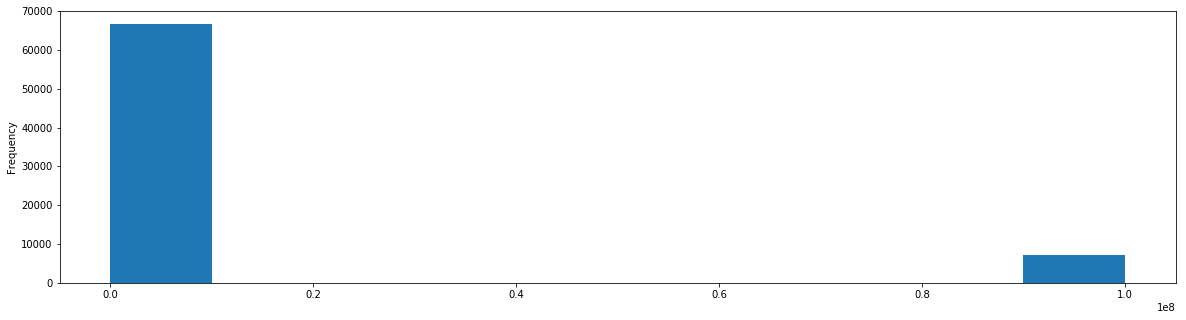

In [9]:
df_loan.cur_loan_amount.plot(kind='hist', figsize=(20, 5))

We immediately see the issue - this distribution is really skewed, and there is a single anomalously high value to blame: 

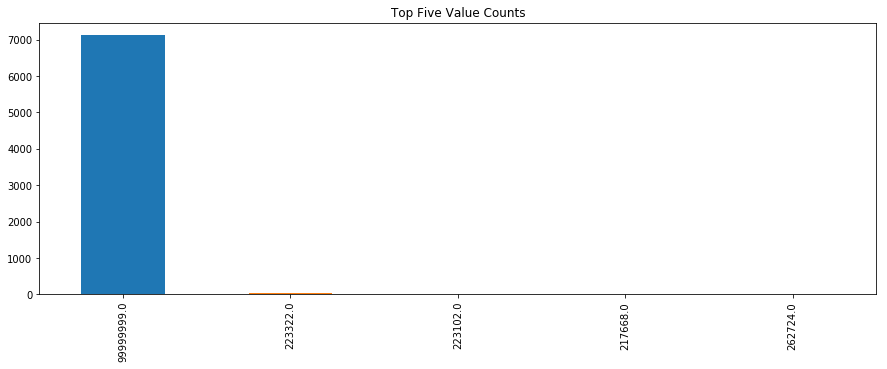

In [14]:
df_loan.cur_loan_amount.value_counts().head().plot(kind='bar', title='Top Five Value Counts', figsize=(15, 5))

Distribution below that value looks just fine:

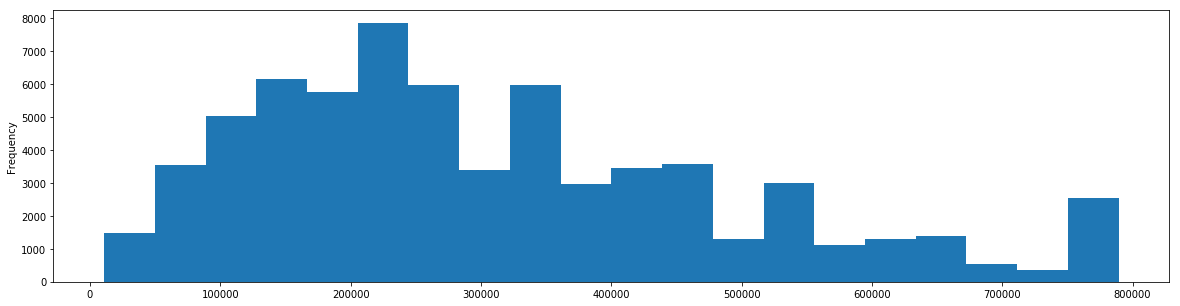

In [15]:
df_loan[df_loan.cur_loan_amount < 99999999.0].cur_loan_amount.plot(kind='hist', figsize=(20, 5),
                                                                  bins=20)

Let's digg more into that value. In particular, what we can tell about loan outcome for the cases with this extreme value:

In [18]:
df_loan[df_loan.cur_loan_amount == 99999999.0].loan_status.value_counts()

0    7116
Name: loan_status, dtype: int64

It turns out, this high value only appears in the negative class cases. 
Therefore, a machine learning algorithm can pick it up as a good predictor. But we should be very careful about this, as this might be just a data anomaly, and it may not represent actual real-world tendency.

We will deal with this specific cases later.

Now, let's take a look at the distibution of this predictor for two classes in the same plot.
Note: We will make this type of plots for the rest of features in our dataset. Typically, this way of looking at a predictor gives a rough idea how useful this predictor is. 

#### Current Loan Amount Distribution for two classes:

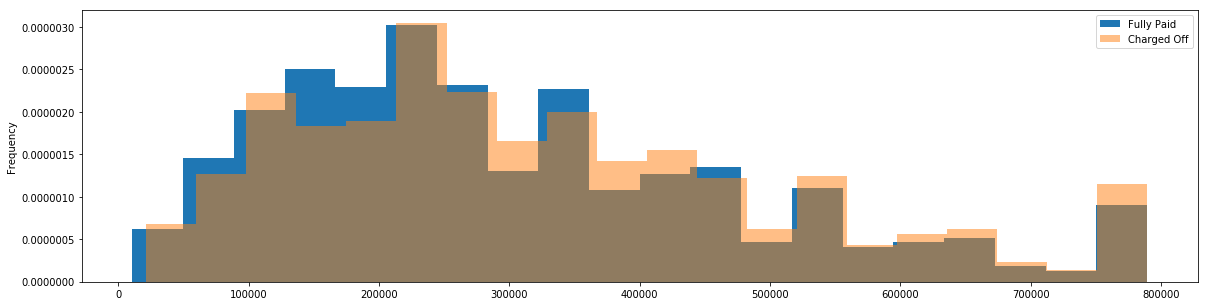

In [21]:
neg_class[neg_class.cur_loan_amount < 99999999.0].cur_loan_amount.plot(kind='hist', figsize=(20, 5),
                                                                  bins=20, density=True, 
                                                                  label='Fully Paid', legend=True)
pos_class.cur_loan_amount.plot(kind='hist', figsize=(20, 5), bins=20, density=True, alpha=0.5,
                              label='Charged Off', legend=True)

Since, this is a long-tail distribution, it would probably look closer to normal in a log-scale:

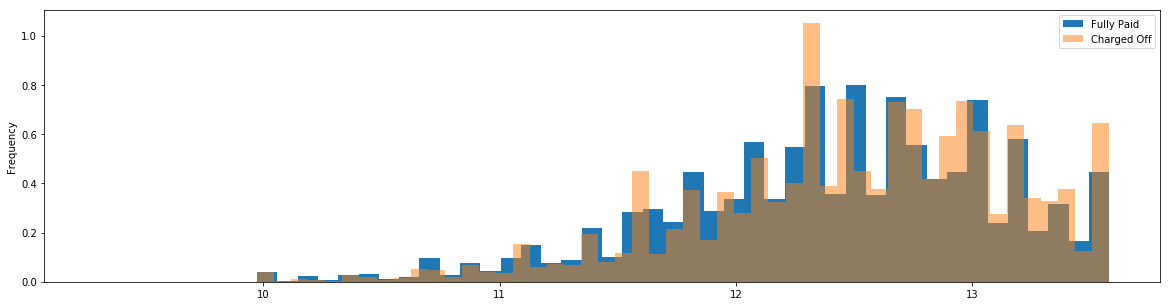

In [23]:
neg_class[neg_class.cur_loan_amount < 99999999.0].cur_loan_amount.apply(lambda x: np.log(x + 1.)).plot(kind='hist', figsize=(20, 5),
                                                            bins=50, density=True,
                                                            label='Fully Paid', legend=True)
pos_class.cur_loan_amount.apply(lambda x: np.log(x + 1.)).plot(kind='hist', figsize=(20, 5),
                                                           bins=50, density=True, alpha=0.5,
                                                           label='Charged Off', legend=True)

### Credit Score Distribution

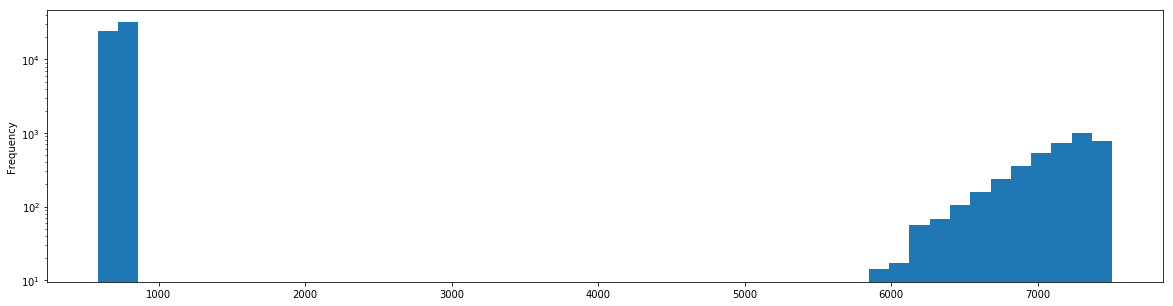

In [35]:
df_loan.credit_score.plot(kind='hist', figsize=(20, 5), bins=50, logy=True)

In the credit score distribution things are not better. There are two classes of usual scores and very high scores.

Let's take a look at those which are not very high:

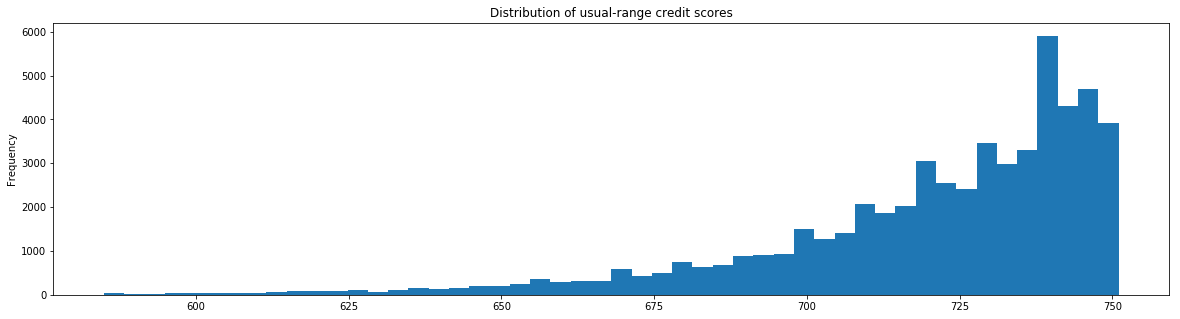

In [25]:
df_loan[df_loan.credit_score < 5000.].credit_score.plot(kind='hist', figsize=(20, 5), bins=50, logy=False,
                                                       title='Distribution of usual-range credit scores')

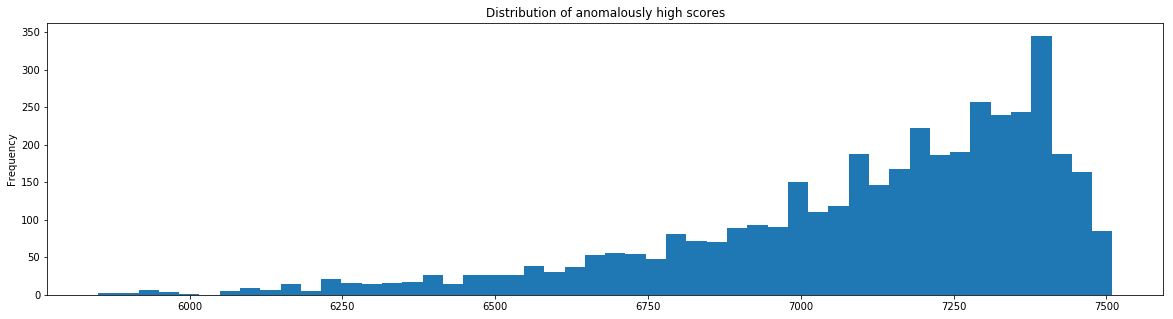

In [26]:
df_loan[df_loan.credit_score > 5000.].credit_score.plot(kind='hist', figsize=(20, 5), bins=50, logy=False,
                                                       title='Distribution of anomalously high scores')

Wait a second! These are two very similar distributions sitting in completely different ranges. 

And if you take a closer look - they are off by a factor of `10`. So, what we will do later in transformation part is divide excessively high credit scores by `10`. My guess is that there was an error in data collection phase. Part of a data scientist's job is to spot such errors to avoid wrong modelling.

Now, let's take look at distributions of two classess (with taking into account of correction factor):

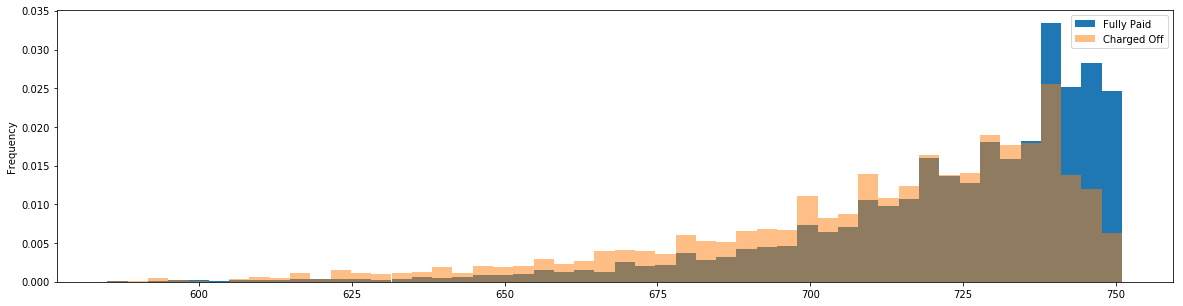

In [27]:
neg_class[neg_class.credit_score < 5000.].credit_score.plot(kind='hist', figsize=(20, 5),
                                                       bins=50, density=True, label='Fully Paid', legend=True)
pos_class[pos_class.credit_score > 5000.].credit_score.div(10).plot(kind='hist', figsize=(20, 5),
                                                       bins=50, density=True, alpha=0.5, label='Charged Off',
                                                               legend=True)

There is definitely a difference in distributions. That means that credit score should be a good predictor of default.

### Years at current job

How years at current job affects the loan outcome?

We will take a look at the percentage of defaults for each class of `years at current` job variable.

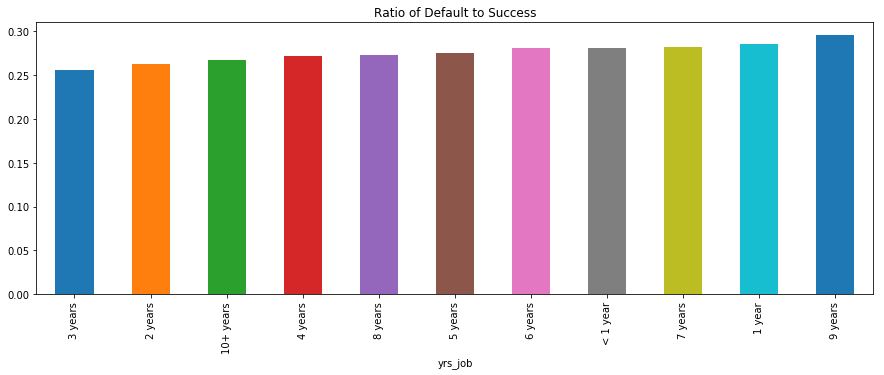

In [35]:
df_loan.groupby('yrs_job').loan_status.mean().sort_values().plot(
    kind='bar', figsize=(15, 5), title='Ratio of Default to Success')

Interesting enough that the highest ratio of default loans is for the cases of 9 years at current job. But we should be careful before making any conclusions, as if we take a look at number of cases for different values of this predictor, we will see that '9 years' has least amount of cases, and therefore the variance can be very high, and the default ratio is just high by chance:

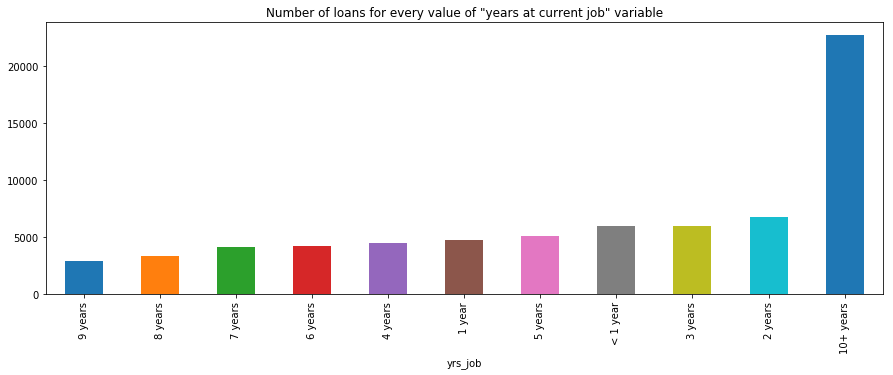

In [36]:
df_loan.groupby('yrs_job').customer_id.count().sort_values().plot(
    kind='bar', figsize=(15, 5), title='Number of loans for every value of "years at current job" variable')

### Annual Income Distribution

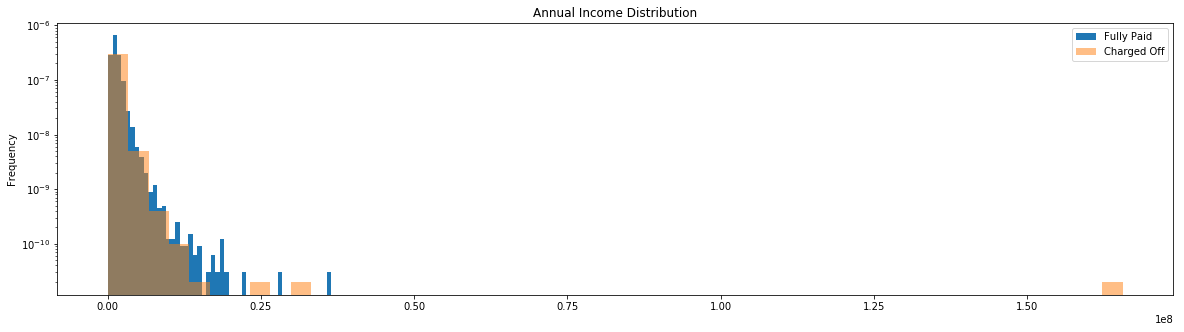

In [39]:
neg_class.annual_income.plot(kind='hist', figsize=(20, 5),
    bins=50, density=True, label='Fully Paid', legend=True, logy=True)
pos_class.annual_income.plot(kind='hist', figsize=(20, 5),
    bins=50, density=True, alpha=0.5, label='Charged Off', legend=True, logy=True,
                            title='Annual Income Distribution')

This is a long-tail distribution. It means that there are some cases with very high annual income:

In [40]:
pos_class[pos_class.annual_income > 1.5e8]

,loan_id,customer_id,loan_status,cur_loan_amount,term,credit_score,annual_income,yrs_job,home_own,purpose,monthly_debt,yrs_credit,months_delinq,num_acc,num_probl,cur_bal,max_open,bankrupt,tax_liens
58343,6dfd2f9c-b796-4cb3-8f71-04d6ae8a8f92,ceee183a-9b02-4b82-ae53-14ccd5f785fd,1,176132.0,Short Term,7250.0,165557393.0,10+ years,Home Mortgage,Debt Consolidation,15176.06,16.0,NaN,11.0,0.0,312778.0,669438.0,0.0,0.0


It is very interesting that this case appears to be a default!

Let's look at the same distribution, but in the log scale:

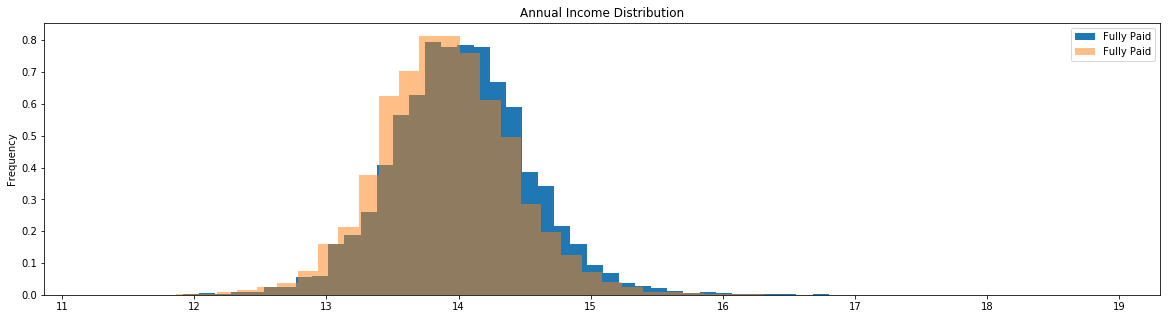

In [42]:
neg_class.annual_income.apply(lambda x: np.log(x + 1.)).plot(kind='hist', figsize=(20, 5),
                                                           bins=50, density=True, label='Fully Paid', legend=True)
pos_class.annual_income.apply(lambda x: np.log(x + 1.)).plot(kind='hist', figsize=(20, 5),
                                                           bins=50, density=True, alpha=0.5,
                                                             label='Fully Paid', legend=True,
                                                            title='Annual Income Distribution')

### Loan Term

Counts of different cases:

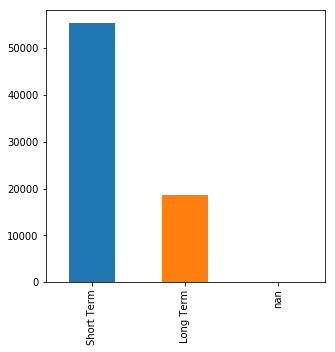

In [164]:
df_loan.term.value_counts(dropna=False).plot(kind='bar', figsize=(5, 5))

What is the ratio of default for different cases:

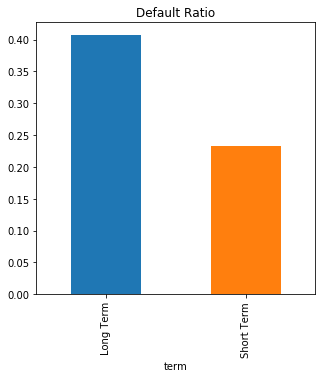

In [45]:
df_loan.groupby('term').loan_status.mean().plot(kind='bar', figsize=(5, 5),
                                               title='Default Ratio')

Long Term loans are much riskier. But keep in mind that they represent smaller part of cases.

### Home owner

Counts:

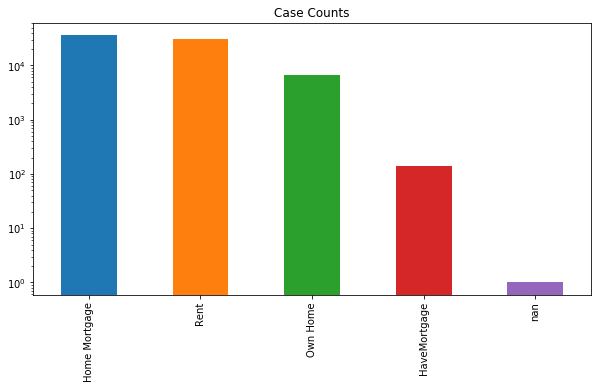

In [46]:
df_loan.home_own.value_counts(dropna=False).plot(kind='bar', figsize=(10, 5), logy=True,
                                                title='Case Counts')

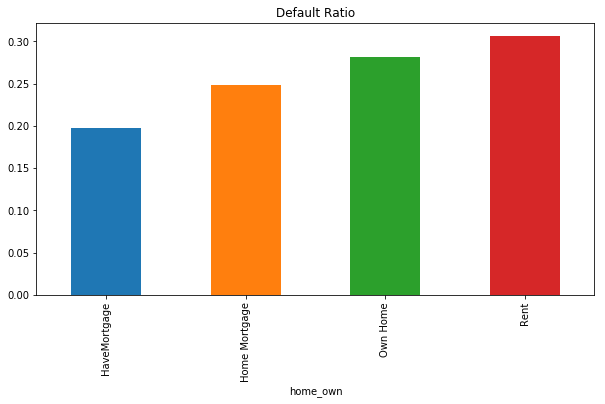

In [47]:
df_loan.groupby('home_own').loan_status.mean().plot(kind='bar', figsize=(10, 5),
                                                   title='Default Ratio')

The risk is definitely higher for those who rent.

### Loan Purpose

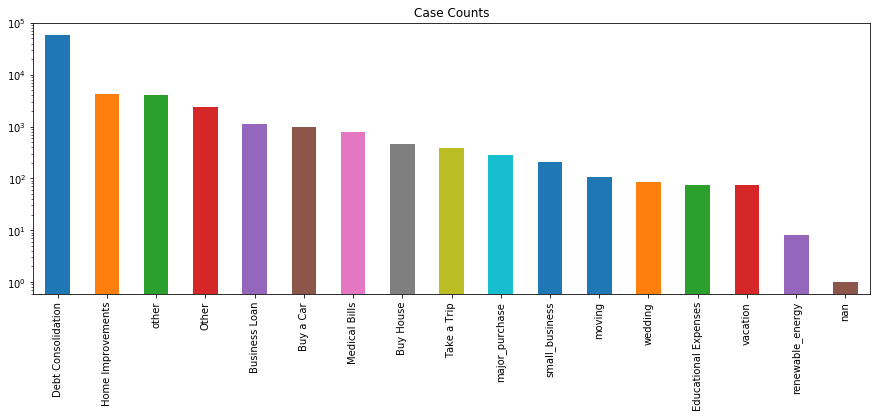

In [48]:
df_loan.purpose.value_counts(dropna=False).plot(kind='bar', figsize=(15, 5), logy=True,
                                               title='Case Counts')

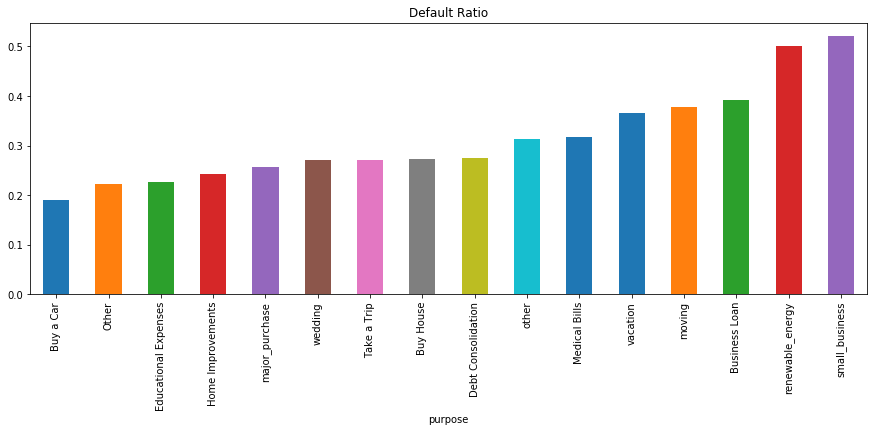

In [49]:
df_loan.groupby('purpose').loan_status.mean().sort_values().plot(kind='bar', figsize=(15, 5),
                                                                title='Default Ratio')

Loans taken to start a small business are very risky ones. 

On the data cleaning part, note that we have two equivalent values - `Other` and `other`. We will combine them together in transformation part.

### Monthly Debt Distribution

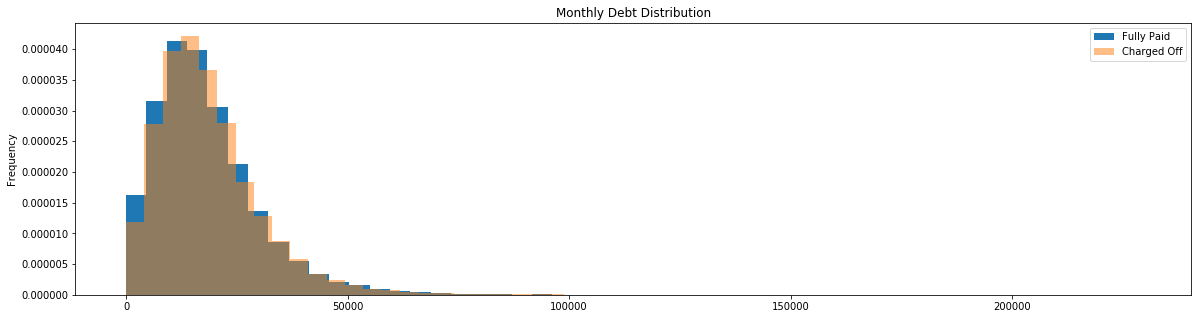

In [51]:
neg_class.monthly_debt.plot(kind='hist', figsize=(20, 5),
    bins=50, density=True, label='Fully Paid', legend=True)
pos_class.monthly_debt.plot(kind='hist', figsize=(20, 5),
    bins=50, density=True, alpha=0.5, label='Charged Off', legend=True,
                           title='Monthly Debt Distribution')

Another long-tail distribution, that looks a bit closer to normal one after the log transformation:

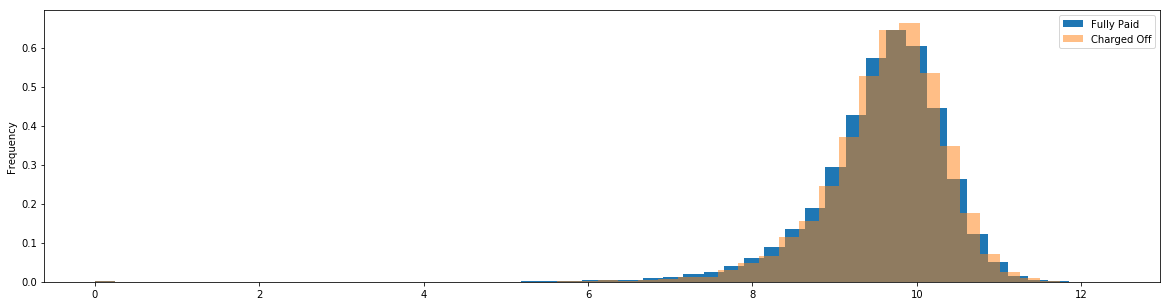

In [52]:
neg_class.monthly_debt.apply(lambda x: np.log(x + 1.)).plot(kind='hist', figsize=(20, 5),
    bins=50, density=True, label='Fully Paid', legend=True)
pos_class.monthly_debt.apply(lambda x: np.log(x + 1.)).plot(kind='hist', figsize=(20, 5),
    bins=50, density=True, alpha=0.5, label='Charged Off', legend=True)

### Years of credit history

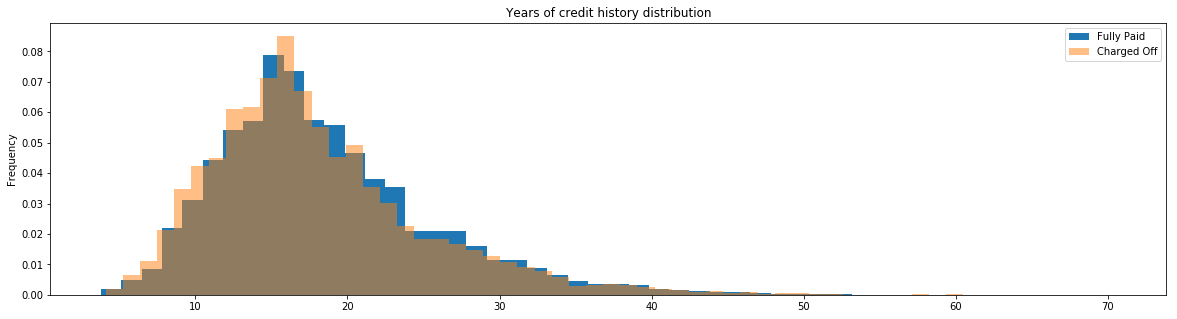

In [54]:
neg_class.yrs_credit.plot(kind='hist', figsize=(20, 5),
    bins=50, density=True, label='Fully Paid', legend=True)
pos_class.yrs_credit.plot(kind='hist', figsize=(20, 5),
    bins=50, density=True, alpha=0.5, label='Charged Off', legend=True,
                           title='Years of credit history distribution')

#### Month of Delinquency

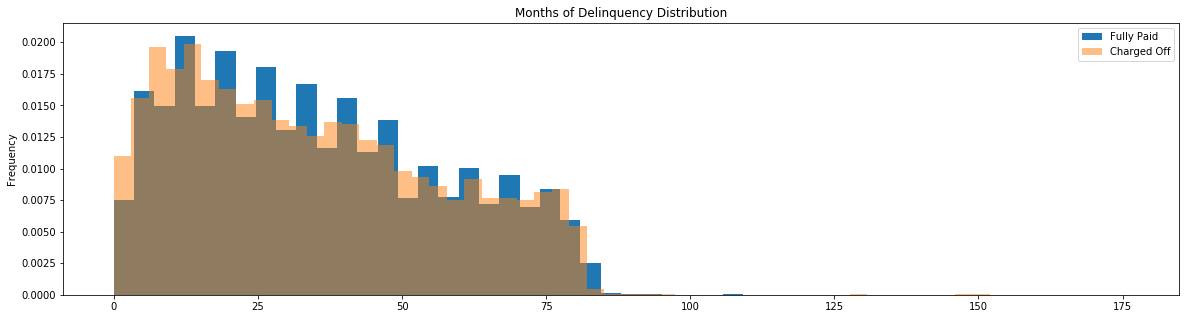

In [55]:
neg_class.months_delinq.plot(kind='hist', figsize=(20, 5),
    bins=50, density=True, label='Fully Paid', legend=True)
pos_class.months_delinq.plot(kind='hist', figsize=(20, 5),
    bins=50, density=True, alpha=0.5, label='Charged Off', legend=True,
                           title='Months of Delinquency Distribution')

### Number of accounts

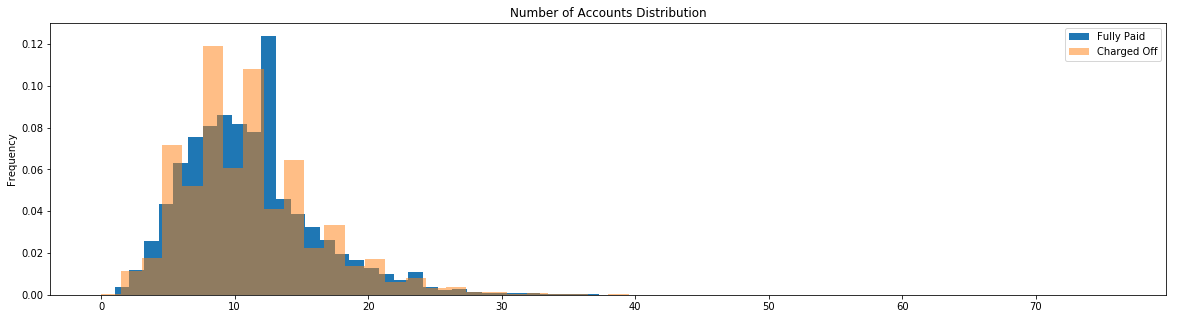

In [56]:
neg_class.num_acc.plot(kind='hist', figsize=(20, 5),
    bins=50, density=True, label='Fully Paid', legend=True)
pos_class.num_acc.plot(kind='hist', figsize=(20, 5),
    bins=50, density=True, alpha=0.5, label='Charged Off', legend=True,
                           title='Number of Accounts Distribution')

After log transformation:

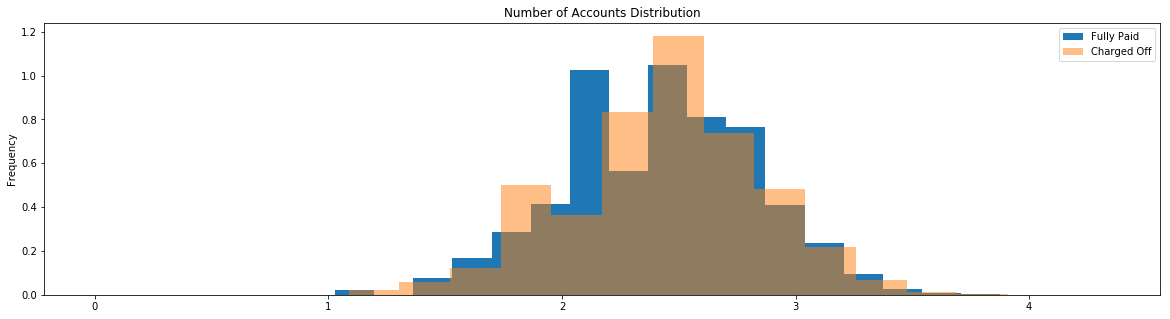

In [58]:
neg_class.num_acc.apply(lambda x: np.log(x + 1.)).plot(kind='hist', figsize=(20, 5),
    bins=20, density=True, label='Fully Paid', legend=True)
pos_class.num_acc.apply(lambda x: np.log(x + 1.)).plot(kind='hist', figsize=(20, 5),
    bins=20, density=True, alpha=0.5, label='Charged Off', legend=True,
                           title='Number of Accounts Distribution')

### Number of credit problems

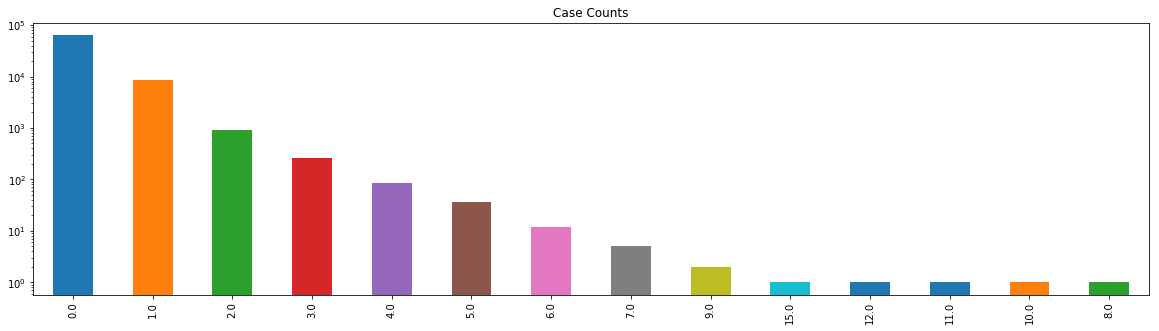

In [60]:
df_loan.num_probl.value_counts().plot(kind='bar', figsize=(20, 5), logy=True,
                                     title='Case Counts')

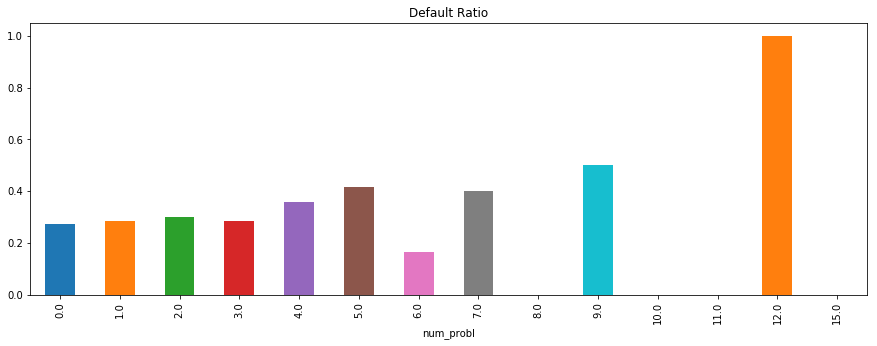

In [61]:
df_loan.groupby('num_probl').loan_status.mean().plot(kind='bar', figsize=(15, 5),
                                                    title='Default Ratio')

### Current Balance

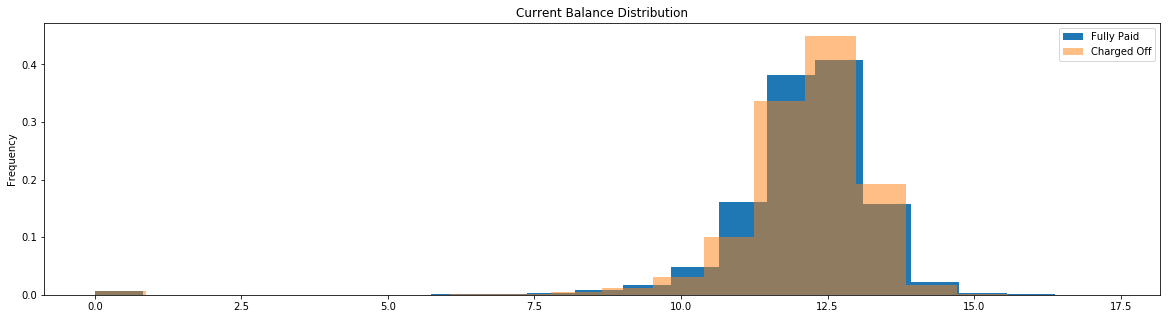

In [62]:
neg_class.cur_bal.apply(lambda x: np.log(x + 1.)).plot(kind='hist', figsize=(20, 5),
    bins=20, density=True, label='Fully Paid', legend=True)
pos_class.cur_bal.apply(lambda x: np.log(x + 1.)).plot(kind='hist', figsize=(20, 5),
    bins=20, density=True, alpha=0.5, label='Charged Off', legend=True,
                           title='Current Balance Distribution')

### Maximum number of open credits

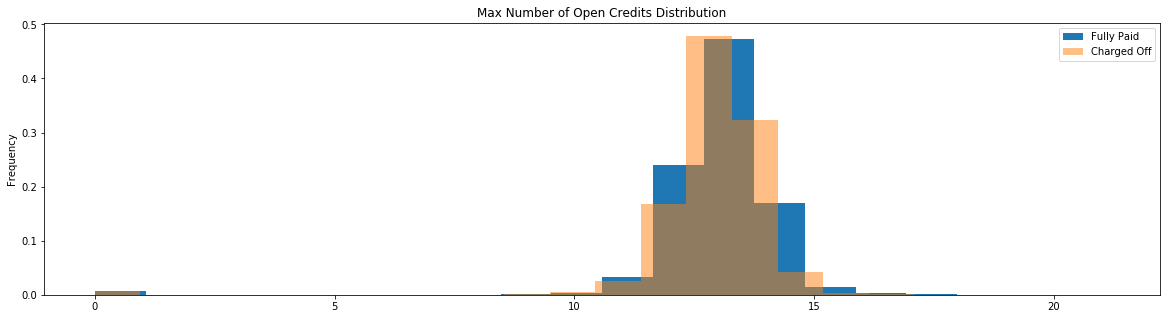

In [63]:
neg_class.max_open.apply(lambda x: np.log(x + 1.)).plot(kind='hist', figsize=(20, 5),
    bins=20, density=True, label='Fully Paid', legend=True)
pos_class.max_open.apply(lambda x: np.log(x + 1.)).plot(kind='hist', figsize=(20, 5),
    bins=20, density=True, alpha=0.5, label='Charged Off', legend=True,
                           title='Max Number of Open Credits Distribution')

### Bankruptcies

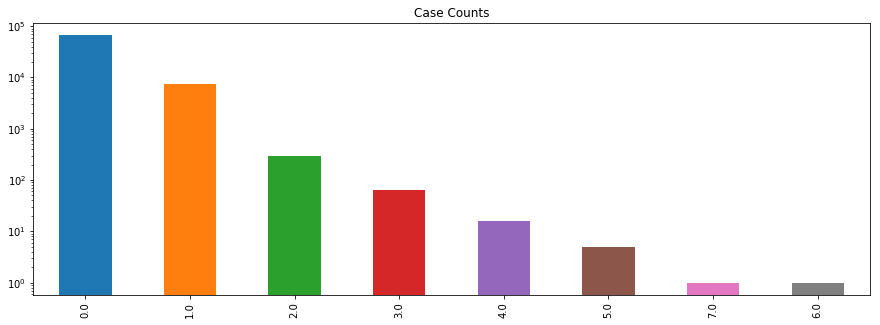

In [66]:
df_loan.bankrupt.value_counts().plot(kind='bar', figsize=(15, 5),
                                    title='Case Counts', logy=True)

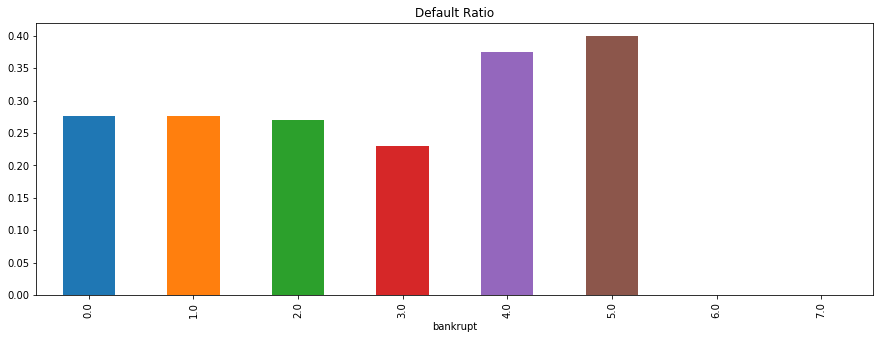

In [67]:
df_loan.groupby('bankrupt').loan_status.mean().plot(kind='bar', figsize=(15, 5),
                                                   title='Default Ratio')

Ratio of defaults is very high for the cases of 4 and 5 bankruptcies. But keep in mind that those cases are very rare.

### Tax Liens

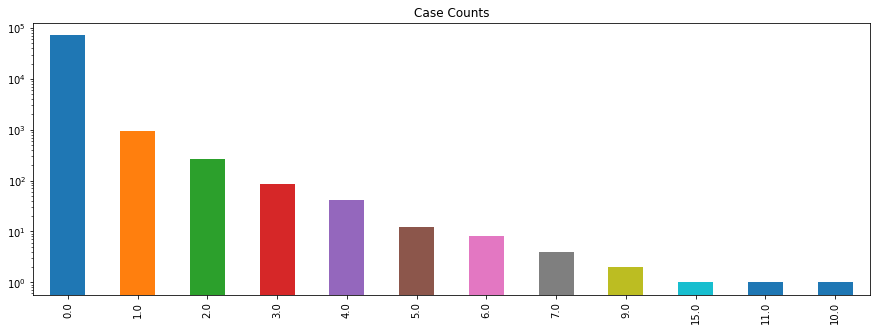

In [69]:
df_loan.tax_liens.value_counts().plot(kind='bar', figsize=(15, 5), title='Case Counts', logy=True)

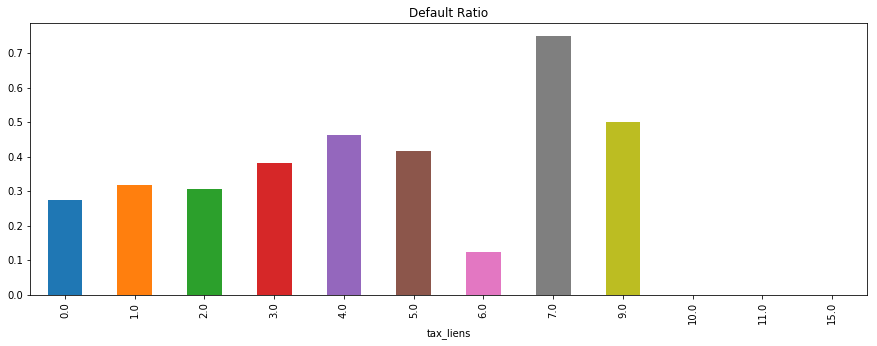

In [71]:
df_loan.groupby('tax_liens').loan_status.mean().plot(kind='bar', figsize=(15, 5),
                                                    title='Default Ratio')

## Conclusion

This quick exploratory analysis gave us deeper understanding of the dataset. As a next step in the following notebook, we will do data transformation to prepare it for modeling part. 

We will take into account the findings that we obtained here. We will treat continuous and discrete features in a different manner. Stay tuned!